In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mczielinski/bitcoin-historical-data


 82% 82.0M/100M [00:00<00:00, 98.3MB/s]
100% 100M/100M [00:00<00:00, 108MB/s]  


In [8]:
import os
import zipfile
from tqdm import tqdm


zip_file_name = 'bitcoin-historical-data.zip'


target_directory = '/content'


os.makedirs(target_directory, exist_ok=True)


with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())


with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    for file_info in tqdm(zip_ref.infolist(), desc="Extracting", unit=" files", ncols=100):
        zip_ref.extract(file_info, target_directory)


Extracting: 100%|█████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/ files]


In [7]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

Upload bitcoin timeseries data
convert minute data to daily data

In [9]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
df.set_index('Timestamp', inplace=True)
df = df.resample('D').mean()

simple check for the data

In [10]:
# data describe
df.describe()
# check null value
print(df[df["Weighted_Price"].isna()==True])

            Open  High  Low  Close  Volume_(BTC)  Volume_(Currency)  \
Timestamp                                                             
2015-01-06   NaN   NaN  NaN    NaN           NaN                NaN   
2015-01-07   NaN   NaN  NaN    NaN           NaN                NaN   
2015-01-08   NaN   NaN  NaN    NaN           NaN                NaN   

            Weighted_Price  
Timestamp                   
2015-01-06             NaN  
2015-01-07             NaN  
2015-01-08             NaN  


Impute null data with KNNImputer

In [11]:
# KNN imputation - impute null data with KNNImputer
Kimp = KNNImputer(n_neighbors=10)
df = pd.DataFrame(Kimp.fit_transform(df), index=df.index, columns=df.columns)


Normalize data

In [12]:
# normalize
def normalize(data):
    mean = data.mean()
    std = data.std()
    return (data-mean)/std


df_norm = normalize(df)

Check Multi Collinearity and eliminate it with VIF

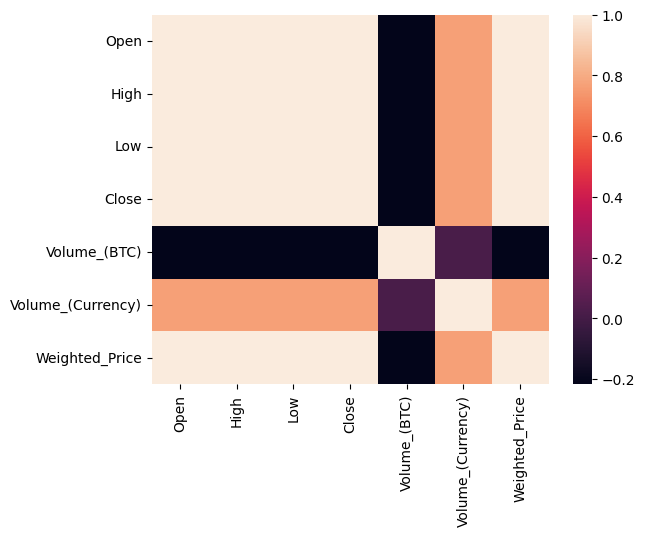

In [13]:
# simple check by watching the heatmap
sns.heatmap(df_norm.corr())
# create vif dataframe
vif = pd.DataFrame()
vif['vif_factor'] = [variance_inflation_factor(df_norm.values, i) for i in range(df_norm.shape[1])]
vif['feature'] = df.columns

# get rid of 'Volume_(Currency)' which has the highest multiCollinearity
df_norm.drop('Volume_(Currency)', axis=1, inplace=True)



Check Stationary with adfuller -> We can see every feature is non-station

In [14]:
cols = df_norm.columns
for col in cols:
    print("Augmented Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_norm[col])[1])


Augmented Dickey–Fuller test: p=1.000000
Augmented Dickey–Fuller test: p=1.000000
Augmented Dickey–Fuller test: p=1.000000
Augmented Dickey–Fuller test: p=1.000000
Augmented Dickey–Fuller test: p=0.000394
Augmented Dickey–Fuller test: p=1.000000


BUT I won't transform it to stationary data. Because RNN is strong enough to deal with non stationary data

Simple Function for RNN

In [16]:
def data_for_rnn(input, seq_len):
    x_li = []
    x_idx = input.index[seq_len-1:-1]
    for i in range(len(input)-seq_len):
        x_li.append(input.iloc[i:i+seq_len].values)
    return x_li, x_idx

def RNNmodel(out_shape, seq_len, n_feature):
    out_shape = out_shape

    model = models.Sequential()
    model.add(layers.Input(shape=(seq_len, n_feature), name='input'))
    model.add(layers.LSTM(128, activation='relu', return_sequences=True, name='first'))
    model.add(layers.LSTM(64, activation='relu', name='second'))
    model.add(layers.Dense(out_shape))
    model.summary()
    model.compile(optimizer='adam',
                  loss = 'mse',
                  metrics=['accuracy'])
    return model

convert x, y to be good pair for tf model

In [17]:
seq_len = 20

x_rnn, x_idx = data_for_rnn(df_norm['Weighted_Price'], seq_len)
x_rnn = tf.convert_to_tensor(np.expand_dims(x_rnn, axis=2))

y = df['Weighted_Price'].iloc[20:]
y = normalize(y)
y_rnn = tf.convert_to_tensor(np.expand_dims(y, axis=1))

trn_size = int(len(x_rnn)*0.7)
val_size = int(len(x_rnn)*0.1)

x_trn = x_rnn[:trn_size]
x_val = x_rnn[trn_size:trn_size+val_size]
x_tst = x_rnn[trn_size+val_size:]


y_trn = y_rnn[:trn_size]
y_val = y_rnn[trn_size:trn_size+val_size]
y_tst = y_rnn[trn_size+val_size:]


execute the model

In [18]:
model = RNNmodel(out_shape=1, seq_len=seq_len, n_feature=1)
model.summary()
model.fit(x_trn, y_trn, epochs=40, validation_data=(x_val, y_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first (LSTM)                (None, 20, 128)           66560     
                                                                 
 second (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116033 (453.25 KB)
Trainable params: 116033 (453.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first (LSTM)                (None, 20, 128)           66560     
                                                              

plot train data and prediction simultaneously

22/22 [==============================] - 1s 13ms/step


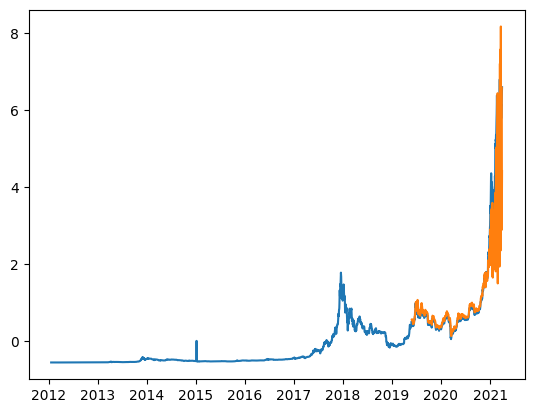

In [19]:
pred = model.predict(x_tst)
pred_df = pd.DataFrame(pred, index=y.index[+trn_size+val_size:])
plt.plot(y)
plt.plot(pred_df)
plt.show()